In [0]:
# Setup: Spark session and imports
import os
import math
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

try:
    from pyspark.sql import SparkSession
    from pyspark.sql import functions as F
    from pyspark.sql import types as T
    spark = SparkSession.builder.getOrCreate()
except Exception as e:
    raise RuntimeError("Spark is required. Please run in Databricks or with PySpark.")

spark.conf.set('spark.sql.shuffle.partitions', '200')

print(f'Spark version: {spark.version}')

Spark version: 4.0.0


## Data Generation Design
We synthesize trips with:
- Yearly trend: 2021 depressed demand; recovery in 2022–2023; strong growth in 2024–2025.
- Seasonality: higher in summer and holidays; lower in Jan–Feb.
- Day-of-week: **weekends show significantly higher demand** (Sat +25%, Sun +20%, Fri +10%).
- **Holidays: major US holidays show +35% increased demand** (New Year's, MLK Day, Presidents' Day, Memorial Day, Independence Day, Labor Day, Columbus Day, Veterans Day, Thanksgiving, Christmas, New Year's Eve).
- Time-of-day: commute peaks 7–9am and 4–7pm; nightlife 10pm–2am.
- Zones: pickups in Manhattan, Brooklyn, Queens, Bronx, Staten Island, airports (JFK/LGA) with varying patterns.
- Distance and duration correlated with zone pairs and congestion proxies.
- Fares: base + per-mile + per-minute + surcharges + tips, with surge on demand spikes.
- Vendor and payment type distributions.


In [0]:
# Synthetic NYC Taxi data generator (2021–2025)
random.seed(42)
np.random.seed(42)

years = list(range(2021, 2026))
zones = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island", "JFK", "LGA"]
vendors = ["CMT", "VTS"]
payment_types = ["CARD", "CASH", "E-PAY"]

# Define US holidays for increased demand
us_holidays = [
    # 2021
    "2021-01-01", "2021-01-18", "2021-02-15", "2021-05-31", "2021-07-04", "2021-07-05",
    "2021-09-06", "2021-10-11", "2021-11-11", "2021-11-25", "2021-12-24", "2021-12-25", "2021-12-31",
    # 2022
    "2022-01-01", "2022-01-17", "2022-02-21", "2022-05-30", "2022-07-04", 
    "2022-09-05", "2022-10-10", "2022-11-11", "2022-11-24", "2022-12-24", "2022-12-25", "2022-12-26", "2022-12-31",
    # 2023
    "2023-01-01", "2023-01-02", "2023-01-16", "2023-02-20", "2023-05-29", "2023-07-04", 
    "2023-09-04", "2023-10-09", "2023-11-10", "2023-11-23", "2023-12-24", "2023-12-25", "2023-12-31",
    # 2024
    "2024-01-01", "2024-01-15", "2024-02-19", "2024-05-27", "2024-07-04", 
    "2024-09-02", "2024-10-14", "2024-11-11", "2024-11-28", "2024-12-24", "2024-12-25", "2024-12-31",
    # 2025
    "2025-01-01", "2025-01-20", "2025-02-17", "2025-05-26", "2025-07-04", 
    "2025-09-01", "2025-10-13", "2025-11-11", "2025-11-27", "2025-12-24", "2025-12-25", "2025-12-31",
]
holiday_set = {datetime.strptime(d, '%Y-%m-%d').date() for d in us_holidays}

# Base demand by year (index)
year_demand_index = {
    2021: 0.65,  # depressed demand
    2022: 0.85,
    2023: 1.00,
    2024: 1.15,
    2025: 1.25,
}

# Month seasonality (relative multipliers)
month_seasonality = {
    1: 0.85, 2: 0.88, 3: 0.95, 4: 1.00, 5: 1.05, 6: 1.10,
    7: 1.15, 8: 1.12, 9: 1.03, 10: 1.00, 11: 1.02, 12: 1.12
}

# Day-of-week multiplier (Mon=0) - INCREASED for weekends (Fri=4, Sat=5, Sun=6)
dow_multiplier = {0: 1.00, 1: 1.00, 2: 1.02, 3: 1.02, 4: 1.10, 5: 1.25, 6: 1.20}

# Holiday demand multiplier (significant increase for holidays)
holiday_multiplier = 1.35

# Zone pickup share (normalized later by year)
zone_base_share = {
    "Manhattan": 0.42, "Brooklyn": 0.18, "Queens": 0.16, "Bronx": 0.10, "Staten Island": 0.02, "JFK": 0.07, "LGA": 0.05
}

# Distance distributions by zone pair (miles) rough means
pair_distance_mean = {
    ("Manhattan", "Manhattan"): 2.1,
    ("Manhattan", "Brooklyn"): 5.5,
    ("Manhattan", "Queens"): 7.0,
    ("Manhattan", "Bronx"): 7.2,
    ("Brooklyn", "Queens"): 6.0,
    ("Queens", "JFK"): 11.0,
    ("Queens", "LGA"): 7.5,
}

# Base fare parameters
base_fare = 2.75
per_mile = 2.50
per_minute = 0.60
airport_surcharge = 1.75
night_surcharge = 0.50
peak_surcharge = 0.70

def time_of_day_multiplier(hour):
    # Commute and nightlife bumps
    if 7 <= hour <= 9: return 1.15
    if 16 <= hour <= 19: return 1.20
    if 22 <= hour or hour <= 2: return 1.10
    return 1.0

def surge_multiplier(demand):
    # Simple convex surge function
    return 1.0 + max(0.0, (demand - 1.0) * 0.6)

def generate_day_rows(day_dt, base_count=5000):
    y = day_dt.year
    m = day_dt.month
    dow = day_dt.weekday()
    is_holiday = day_dt.date() in holiday_set
    
    # expected trips for the day - apply holiday multiplier if applicable
    demand = year_demand_index[y] * month_seasonality[m] * dow_multiplier[dow]
    if is_holiday:
        demand *= holiday_multiplier
    
    day_trips = int(base_count * demand * (0.9 + 0.2 * np.random.rand()))
    rows = []
    # Normalize zone shares
    shares = np.array([zone_base_share[z] for z in zones])
    shares = shares / shares.sum()
    zone_choices = np.random.choice(zones, size=day_trips, p=shares)
    for i in range(day_trips):
        pickup_zone = zone_choices[i]
        # sample dropoff with bias: same-zone more likely except airports
        probs = np.array([0.6 if z == pickup_zone else 0.4/ (len(zones)-1) for z in zones])
        probs = probs / probs.sum()
        dropoff_zone = np.random.choice(zones, p=probs)
        # pickup time within the day
        seconds = np.random.randint(0, 24*3600)
        pickup_ts = day_dt + timedelta(seconds=int(seconds))
        hour = pickup_ts.hour
        tod_mult = time_of_day_multiplier(hour)
        # distance and speed proxies
        mean_dist = pair_distance_mean.get((pickup_zone, dropoff_zone), 3.5)
        distance_mi = max(0.5, np.random.lognormal(mean=np.log(mean_dist), sigma=0.35))
        # congestion factor by hour and year (more congestion in later years)
        congestion = 1.0 + 0.10 * (year_demand_index[y]-0.65) + (0.15 if 16 <= hour <= 19 else 0.0)
        avg_speed_mph = max(6.0, np.random.normal(loc=12.0/congestion, scale=2.0))
        duration_min = max(3.0, distance_mi / max(avg_speed_mph, 4.0) * 60.0)
        # fare components
        surcharge = 0.0
        if pickup_zone in ("JFK", "LGA") or dropoff_zone in ("JFK", "LGA"):
            surcharge += airport_surcharge
        if 20 <= hour <= 6:
            surcharge += night_surcharge
        if 16 <= hour <= 19:
            surcharge += peak_surcharge
        demand_mult = surge_multiplier(year_demand_index[y] * month_seasonality[m] * tod_mult)
        fare_amount = (base_fare + per_mile * distance_mi + per_minute * duration_min + surcharge) * demand_mult
        # tips (card more likely to tip)
        payment = np.random.choice(payment_types, p=[0.65, 0.20, 0.15])
        tip_rate = 0.18 if payment == "CARD" else (0.08 if payment == "CASH" else 0.15)
        tip_amount = round(np.random.gamma(shape=2.0, scale=fare_amount*tip_rate/2.0), 2)
        total_amount = round(fare_amount + tip_amount, 2)
        vendor = np.random.choice(vendors)
        passenger_count = int(max(1, min(4, np.random.poisson(1.6))))
        rows.append({
            "trip_id": f"{y}{m:02d}{day_dt.day:02d}-{i}",
            "pickup_datetime": pickup_ts,
            "dropoff_datetime": pickup_ts + timedelta(minutes=float(duration_min)),
            "pickup_zone": pickup_zone,
            "dropoff_zone": dropoff_zone,
            "passenger_count": passenger_count,
            "trip_distance_mi": float(round(distance_mi, 3)),
            "trip_duration_min": float(round(duration_min, 2)),
            "fare_amount": float(round(fare_amount, 2)),
            "tip_amount": float(round(tip_amount, 2)),
            "total_amount": float(total_amount),
            "payment_type": payment,
            "vendor": vendor
        })
    return rows

def generate_data(start_date="2021-01-01", end_date="2025-12-31", base_per_day=5000):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    cur = start
    all_rows = []
    while cur <= end:
        all_rows.extend(generate_day_rows(cur, base_count=base_per_day))
        cur += timedelta(days=1)
    return pd.DataFrame(all_rows)

# For demo speed, generate fewer rows. Adjust as needed.
df_pd = generate_data(base_per_day=1200)
print(df_pd.shape, df_pd.head())

df_bronze = spark.createDataFrame(df_pd)
# df_bronze.cache().count()
df_bronze.printSchema()


(2268546, 13)       trip_id     pickup_datetime  ... payment_type vendor
0  20210101-0 2021-01-01 00:01:57  ...         CASH    CMT
1  20210101-1 2021-01-01 17:52:03  ...         CARD    VTS
2  20210101-2 2021-01-01 08:57:34  ...         CARD    VTS
3  20210101-3 2021-01-01 09:33:07  ...         CASH    VTS
4  20210101-4 2021-01-01 03:23:39  ...         CARD    VTS

[5 rows x 13 columns]
root
 |-- trip_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance_mi: double (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- vendor: string (nullable = true)



## Bronze Tables (Raw)
We maintain the raw trips and create small reference tables in-memory. No writes to catalog.

In [0]:
# Bronze: raw trips and reference
df_trips_bronze = df_bronze

# Reference: zone borough mapping
zone_borough_map = [
    ("Manhattan", "Manhattan"),
    ("Brooklyn", "Brooklyn"),
    ("Queens", "Queens"),
    ("Bronx", "Bronx"),
    ("Staten Island", "Staten Island"),
    ("JFK", "Queens"),
    ("LGA", "Queens"),
]
schema_zone = T.StructType([T.StructField('zone', T.StringType(), False), T.StructField('borough', T.StringType(), False)])
df_zones = spark.createDataFrame(zone_borough_map, schema=schema_zone)

# Reference: vendor info
vendor_data = [("CMT", "Creative Mobile Technologies"), ("VTS", "VeriFone Taxi Systems")]
schema_vendor = T.StructType([T.StructField('vendor', T.StringType(), False), T.StructField('vendor_name', T.StringType(), False)])
df_vendors = spark.createDataFrame(vendor_data, schema=schema_vendor)

print('Bronze counts:', df_trips_bronze.count(), df_zones.count(), df_vendors.count())

Bronze counts: 2268546 7 2


## Silver Tables (Clean + Enriched)
- Remove invalids (negative/zero distances or durations, unrealistic fares).
- Compute derived features: hour, day, month, year, speed, airport flag, surge proxy.
- Join reference data for boroughs and vendors.

In [0]:
# Silver transformations
df_silver = (
    df_trips_bronze
    .withColumn('pickup_date', F.to_date('pickup_datetime'))
    .withColumn('year', F.year('pickup_datetime'))
    .withColumn('month', F.month('pickup_datetime'))
    .withColumn('day', F.dayofmonth('pickup_datetime'))
    .withColumn('hour', F.hour('pickup_datetime'))
    .withColumn('speed_mph', F.when(F.col('trip_duration_min') > 0, F.col('trip_distance_mi') / (F.col('trip_duration_min')/60.0)).otherwise(F.lit(None)))
    .withColumn('airport_trip', F.expr("CASE WHEN pickup_zone IN ('JFK','LGA') OR dropoff_zone IN ('JFK','LGA') THEN 1 ELSE 0 END"))
    .withColumn('surge_proxy', (F.col('total_amount') - F.col('fare_amount')) / F.col('fare_amount'))
    .filter((F.col('trip_distance_mi') > 0.2) & (F.col('trip_duration_min') > 2.0) & (F.col('fare_amount') > 3.0))
    .join(df_zones.withColumnRenamed('zone', 'pickup_zone').withColumnRenamed('borough', 'pickup_borough'), on='pickup_zone', how='left')
    .join(df_zones.withColumnRenamed('zone', 'dropoff_zone').withColumnRenamed('borough', 'dropoff_borough'), on='dropoff_zone', how='left')
    .join(df_vendors, on='vendor', how='left')
)

df_silver.select('trip_id','pickup_datetime','pickup_zone','dropoff_zone','fare_amount','tip_amount','total_amount','speed_mph','airport_trip').show(5)

+----------+-------------------+-----------+-------------+-----------+----------+------------+------------------+------------+
|   trip_id|    pickup_datetime|pickup_zone| dropoff_zone|fare_amount|tip_amount|total_amount|         speed_mph|airport_trip|
+----------+-------------------+-----------+-------------+-----------+----------+------------+------------------+------------+
|20210101-0|2021-01-01 00:01:57|        LGA|          LGA|      20.23|      1.46|       21.69|10.933601609657948|           1|
|20210101-1|2021-01-01 17:52:03|     Queens|          LGA|      61.54|      0.23|       61.77|10.994740796393689|           1|
|20210101-2|2021-01-01 08:57:34|   Brooklyn|     Brooklyn|      63.96|      4.52|       68.48|  8.77847901546229|           0|
|20210101-3|2021-01-01 09:33:07|  Manhattan|       Queens|      34.16|      0.81|       34.97| 13.67150837988827|           0|
|20210101-4|2021-01-01 03:23:39|  Manhattan|Staten Island|      23.01|      3.69|        26.7|12.17704918032786

## Gold Tables (Aggregated KPIs)
We aggregate by date, month, and zone to compute KPIs: trips, revenue, avg fare, tip %, airport share, avg speed.

In [0]:
# Gold aggregations
df_gold_daily = (
    df_silver
    .groupBy('pickup_date','pickup_zone')
    .agg(
        F.count('*').alias('trips'),
        F.sum('total_amount').alias('revenue'),
        F.avg('fare_amount').alias('avg_fare'),
        (F.sum('tip_amount')/F.sum('fare_amount')).alias('tip_pct'),
        F.avg('speed_mph').alias('avg_speed_mph'),
        F.avg(F.col('airport_trip').cast('double')).alias('airport_share')
    )
)

df_gold_monthly = (
    df_silver
    .groupBy('year','month','pickup_zone')
    .agg(
        F.count('*').alias('trips'),
        F.sum('total_amount').alias('revenue'),
        F.avg('fare_amount').alias('avg_fare'),
        (F.sum('tip_amount')/F.sum('fare_amount')).alias('tip_pct'),
        F.avg('speed_mph').alias('avg_speed_mph'),
        F.avg(F.col('airport_trip').cast('double')).alias('airport_share')
    )
)

df_gold_monthly.orderBy('year','month','pickup_zone').show(10)

+----+-----+-------------+-----+------------------+------------------+-------------------+------------------+-------------------+
|year|month|  pickup_zone|trips|           revenue|          avg_fare|            tip_pct|     avg_speed_mph|      airport_share|
+----+-----+-------------+-----+------------------+------------------+-------------------+------------------+-------------------+
|2021|    1|        Bronx| 2155| 60568.60000000006|24.416682134570785|0.15110147772765775|11.718556743377714| 0.1308584686774942|
|2021|    1|     Brooklyn| 3865|         112671.66|25.189156532988363|0.15731496612076323|11.758769118537876|0.13919793014230272|
|2021|    1|          JFK| 1565| 46795.86000000004| 25.93707348242812|0.15284818109792375| 11.72750420208369|                1.0|
|2021|    1|          LGA| 1108|32590.150000000045|25.505433212996397|0.15322459078231349|11.702389240022805|                1.0|
|2021|    1|    Manhattan| 8887| 233640.3600000003|22.735003938336824| 0.1563722277473675|

## Visualizations
We plot monthly revenue trends, day-of-week seasonality, and a simple zone heatmap using a small sample converted to pandas for plotting.

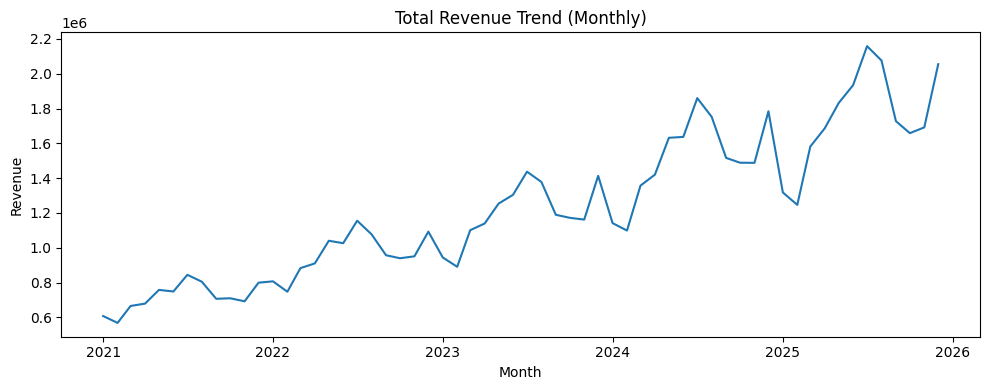

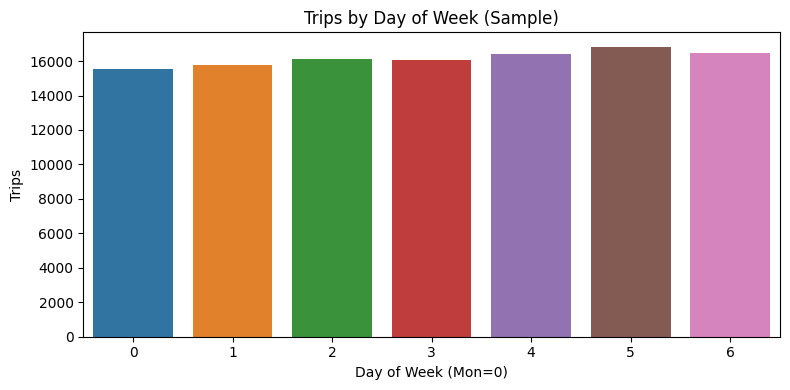

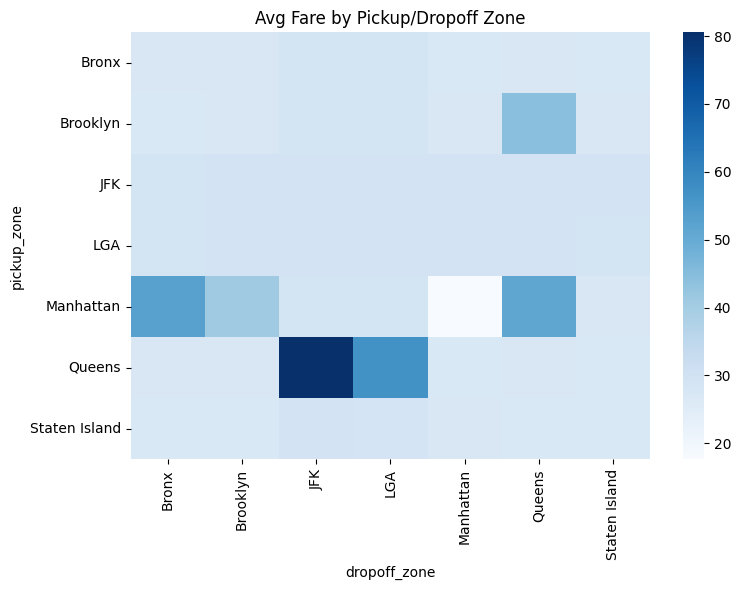

In [0]:
# Convert small aggregates to pandas for plotting
import matplotlib.pyplot as plt
import seaborn as sns

pdf_monthly = df_gold_monthly.orderBy('year','month','pickup_zone').toPandas()
pdf_monthly['year_month'] = pd.to_datetime(pdf_monthly[['year','month']].assign(day=1))

plt.figure(figsize=(10,4))
sns.lineplot(data=pdf_monthly.groupby('year_month', as_index=False)['revenue'].sum(), x='year_month', y='revenue')
plt.title('Total Revenue Trend (Monthly)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

# Day-of-week seasonality on a sample
pdf_silver = df_silver.sample(False, 0.05, seed=7).toPandas()
pdf_silver['dow'] = pdf_silver['pickup_datetime'].dt.dayofweek
plt.figure(figsize=(8,4))
sns.barplot(data=pdf_silver.groupby('dow', as_index=False)['trip_id'].count(), x='dow', y='trip_id')
plt.title('Trips by Day of Week (Sample)')
plt.xlabel('Day of Week (Mon=0)')
plt.ylabel('Trips')
plt.tight_layout()
plt.show()

# Zone heatmap: avg fare by pickup/dropoff
pdf_heat = df_silver.groupBy('pickup_zone','dropoff_zone').agg(F.avg('fare_amount').alias('avg_fare')).toPandas()
pivot = pdf_heat.pivot(index='pickup_zone', columns='dropoff_zone', values='avg_fare')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=False, cmap='Blues')
plt.title('Avg Fare by Pickup/Dropoff Zone')
plt.tight_layout()
plt.show()